# 생체 광학 데이터 분석 AI 경진대회

https://dacon.io/competitions/official/235608/overview/description

In [1]:
# 판다스와 넘파이
import pandas as pd
import numpy as np

# 이미지, 시각화, 분석
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 머신러닝(인공지능), lightgbm, 선형회귀
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 검증평가
from sklearn.multioutput import MultiOutputRegressor # 두 개 이상의 lable을 가질 경우
from sklearn.model_selection import cross_val_score # 교차 검증
from sklearn.metrics import mean_absolute_error # loss 함수 MAE

# 반목문 시간을 알려주는 것, for 반복문 쓴 거 보다 10배 빠름
from tqdm import tqdm
# 무시해도 괜찮은 오류를 안보이게
import warnings ; warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42


In [3]:
# id : index number와 동일. 필요 엄씀.
# src 입사광 강도
# dst 투과, 반사광 강도
# rho : 측정거리(mm) 25, 10, 15, 20
train['rho'].unique()

array([25, 10, 15, 20], dtype=int64)

In [4]:
#입사광은 빈값이 엄씀
#값이 낮은 건 노이즈 등등
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   rho      10000 non-null  int64  
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

<AxesSubplot:>

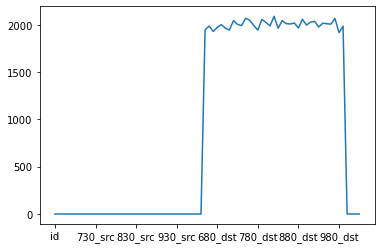

In [5]:
# 시각화르 통해 빈 값을 한 눈에 알아 볼 수 있다
# train.isnull().sum() 빈값 표시
# plot 으로
train.isnull().sum().plot()

In [6]:
train.columns

Index(['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src',
       '700_src', '710_src', '720_src', '730_src', '740_src', '750_src',
       '760_src', '770_src', '780_src', '790_src', '800_src', '810_src',
       '820_src', '830_src', '840_src', '850_src', '860_src', '870_src',
       '880_src', '890_src', '900_src', '910_src', '920_src', '930_src',
       '940_src', '950_src', '960_src', '970_src', '980_src', '990_src',
       '650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst', 'hhb', 'hbo2',
       'ca', 'na'],
      dtype='object')

In [7]:
column = ['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']
train[column].head()

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,...,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17
1,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,...,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN
2,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN
3,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,...,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN
4,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,...,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN


In [8]:
# 컬럼 추출
train_dst = train.filter(regex = '_dst$', axis='columns')
train_dst.columns

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')

<AxesSubplot:>

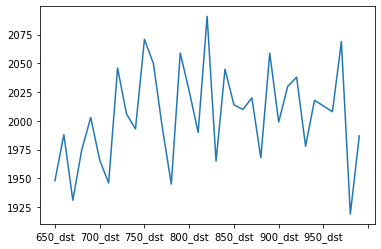

In [9]:
train_dst.isnull().sum().plot()

In [10]:
# 보기 쉽게 뒤집기
train_dst.head().T

,0,1,2,3,4
650_dst,2.447758e-18,0.000000e+00,1.677445e-19,4.044975e-11,4.784751e-14
660_dst,1.894578e-18,0.000000e+00,3.763590e-20,NaN,NaN
670_dst,0.000000e+00,0.000000e+00,NaN,5.345363e-11,0.000000e+00
680_dst,6.412913e-18,1.995530e-10,0.000000e+00,9.106886e-12,1.153089e-13
690_dst,1.098559e-17,1.025259e-10,NaN,1.881458e-11,0.000000e+00
700_dst,8.907142e-19,0.000000e+00,NaN,3.617201e-11,0.000000e+00
710_dst,NaN,0.000000e+00,8.981651e-19,7.909656e-13,1.056991e-13
720_dst,0.000000e+00,0.000000e+00,1.944683e-19,NaN,0.000000e+00
730_dst,NaN,NaN,8.126907e-19,1.583839e-10,0.000000e+00
740_dst,0.000000e+00,0.000000e+00,2.183200e-19,NaN,2.666663e-14


<AxesSubplot:>

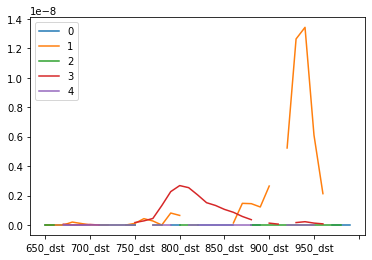

In [11]:
train_dst.head().T.plot()

<AxesSubplot:>

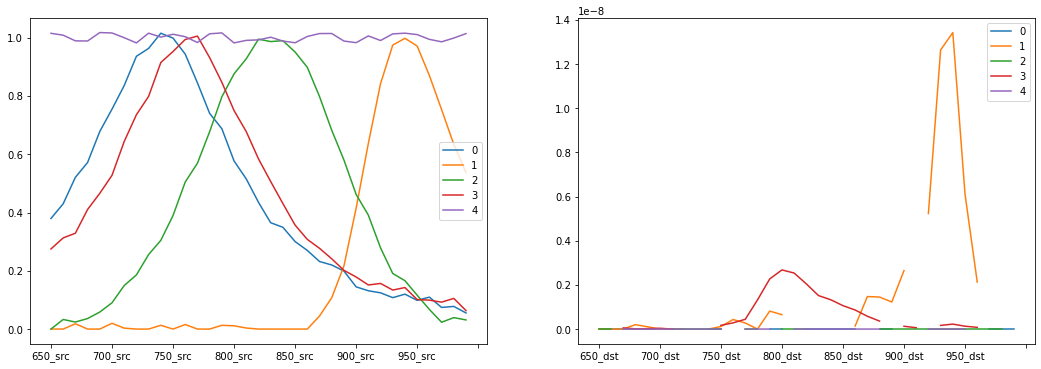

In [12]:
# 입사 투과 강도 1억배 차이
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,6)
train.filter(regex = '_src$', axis='columns').head().T.plot(ax=ax1)
train.filter(regex = '_dst$', axis='columns').head().T.plot(ax=ax2)

## 보간

<AxesSubplot:>

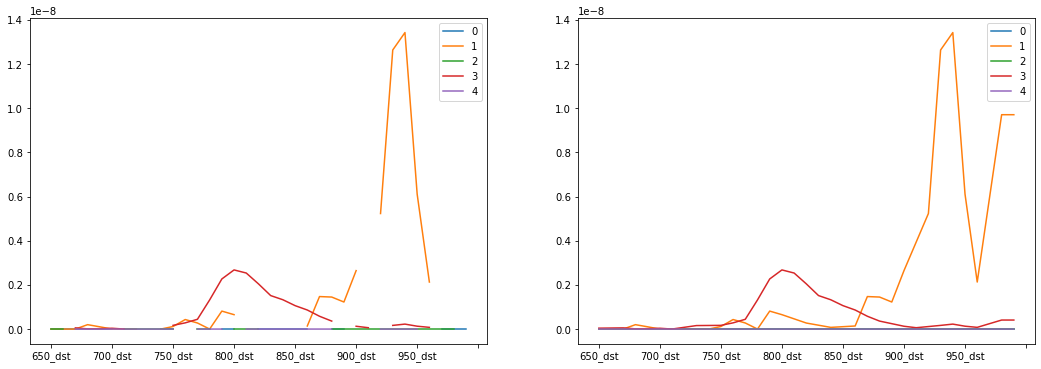

In [13]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,6)
train.filter(regex = '_dst$', axis='columns').head().T.plot(ax=ax1)
train.filter(regex = '_dst$', axis='columns').head().T.interpolate(method='linear',axis=0).plot(ax=ax2)
# axis=0 행(index)방향, axis=1 열(column)방향

In [14]:
train_dst.columns

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')

In [15]:
list(650 + np.arange(35) * 10)

[650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990]

In [16]:
#문자열 컬럼을 숫자 컬럼으로 치환
train_dst.columns = list(650 + np.arange(35) * 10)
train_dst.columns

Int64Index([650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770,
            780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900,
            910, 920, 930, 940, 950, 960, 970, 980, 990],
           dtype='int64')

<AxesSubplot:>

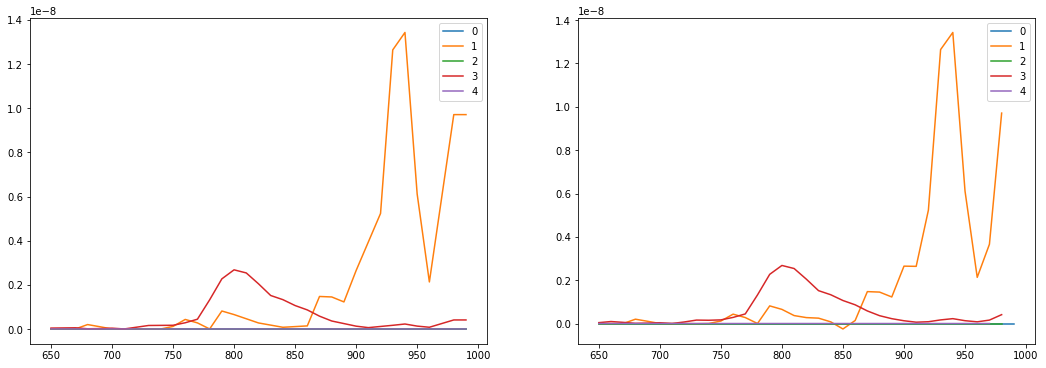

In [17]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18,6)
train_dst.head().T.interpolate(method='linear',axis=0).plot(ax=ax1)
train_dst.head().T.interpolate(method='cubic',axis=0).plot(ax=ax2)

<AxesSubplot:>

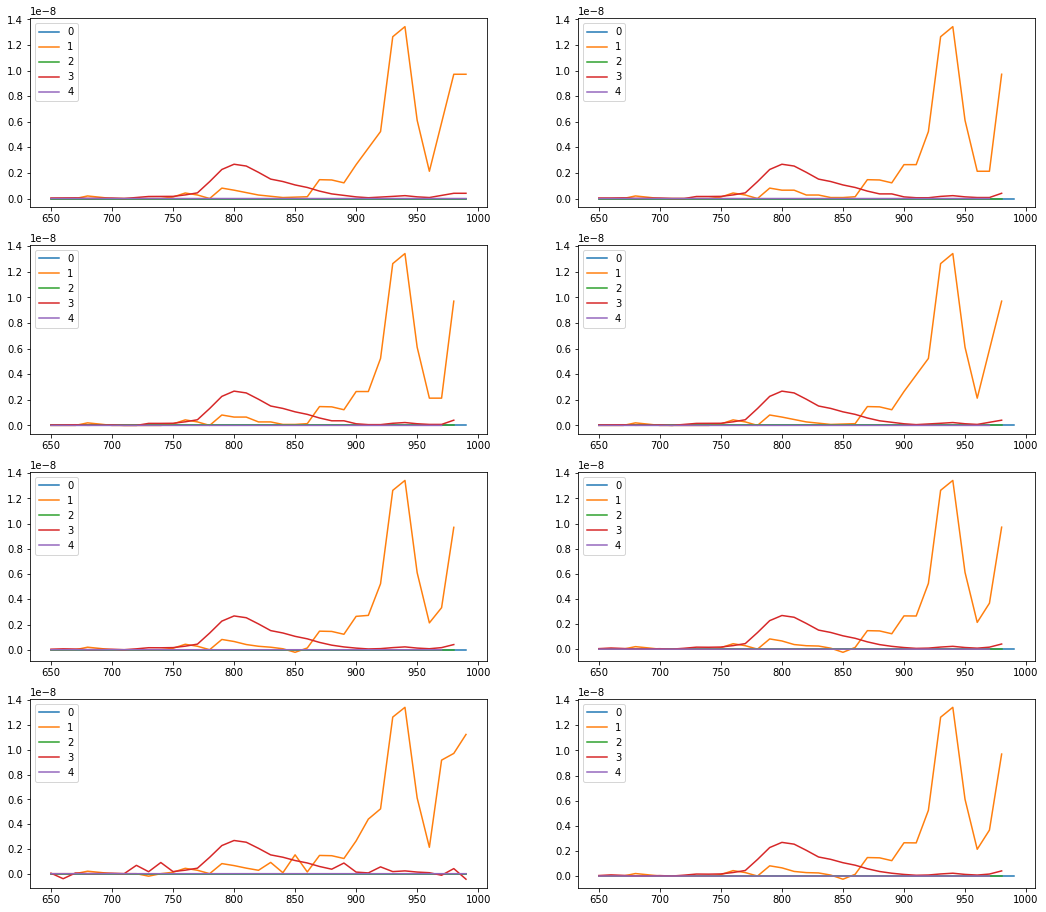

In [18]:
# linear, nearest, zero, slinear, quadratic, cubic, spline, polynomial
figure, ((ax1, ax2),(ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
figure.set_size_inches(18,16)
#직선 보간
train_dst.head().T.interpolate(method='linear',axis=0).plot(ax=ax1)
train_dst.head().T.interpolate(method='nearest',axis=0).plot(ax=ax2)
train_dst.head().T.interpolate(method='zero',axis=0).plot(ax=ax3)
train_dst.head().T.interpolate(method='slinear',axis=0).plot(ax=ax4)
#곡선 보간
train_dst.head().T.interpolate(method='quadratic',axis=0).plot(ax=ax5)
train_dst.head().T.interpolate(method='cubic',axis=0).plot(ax=ax6)
train_dst.head().T.interpolate(method='spline',order=3,axis=0).plot(ax=ax7)
train_dst.head().T.interpolate(method='polynomial',order=3,axis=0).plot(ax=ax8)

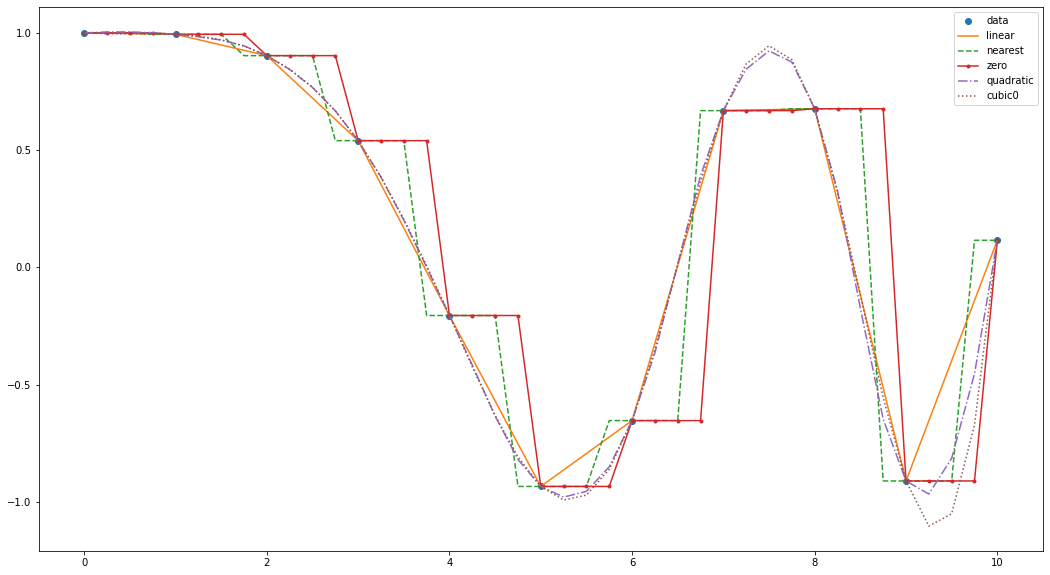

In [19]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint = True)
y = np.cos(-x**2/9)
f = interp1d(x,y) #linear
f2 = interp1d(x,y, kind = 'nearest')
f3 = interp1d(x,y, kind = 'zero')
f4 = interp1d(x,y, kind = 'quadratic')
f5 = interp1d(x,y, kind = 'cubic')

xnew = np.linspace(0,10,num = 41, endpoint = True)

plt.figure(figsize=(18,10))
plt.plot(x,y,'o', 
         xnew, f(xnew), '-',
         xnew, f2(xnew), '--',
         xnew, f3(xnew), '.-', 
         xnew, f4(xnew), '-.', 
         xnew, f5(xnew), ':',)
plt.legend(['data','linear','nearest','zero','quadratic','cubic0'])

In [31]:
train_dst.columns = list(650 + np.arange(35) * 10)# 문자열 컬럼을 숫자 컬럼으로
train_dst = train_dst.interpolate(method='polynomial',order=3,axis=1) # polynomial 보간
train_dst_i = train_dst.interpolate(method='linear',axis=1) # linear 보간
train_dst_i.columns  = train.filter(regex='_dst$',axis='columns').columns # 숫자 컬럼을 문자열 컬럼으로
train_dst_i.columns

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')

In [32]:
test_dst = test.filter(regex='_dst$',axis='columns') #dst 컬럼 추출
test_dst.columns = list(650 + np.arange(35) * 10) #문자여 컬럼 숫자 컬럼 변환
test_dst = test_dst.interpolate(method='polynomial',order=3,axis=1) # polynomial 보간
test_dst_i = test_dst.interpolate(method='linear',axis=1) # linear 보간
test_dst_i.columns  = test.filter(regex='_dst$',axis='columns').columns # 숫자열 컬럼을 문자열 컬럼으로
test_dst_i.columns

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')

<AxesSubplot:>

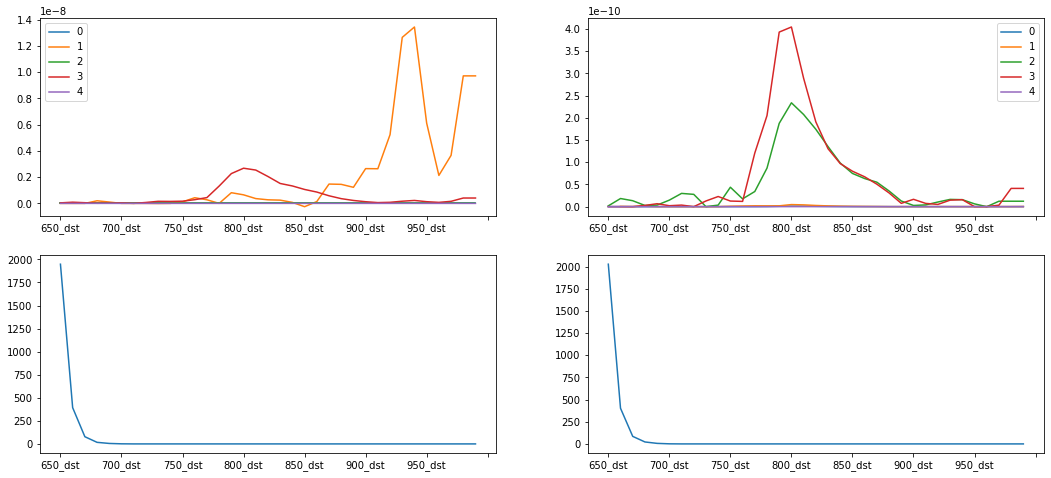

In [33]:
figure, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,8)
train_dst_i.head().T.plot(ax=ax1)
test_dst_i.head().T.plot(ax=ax2)
# 보간 후에도 빈값이 있는지 확인
train_dst_i.isnull().sum().plot(ax=ax3)
test_dst_i.isnull().sum().plot(ax=ax4)

In [38]:
# 오른쪽 값으로 보간
# 문자열에 수식 입력 i = 0 이면 '980_dst', i = 1 이면 '970_dst' ...
# '이런식으로보간하겠다.png'참조
for i in range(34):
    train_dst_i.loc[train_dst_i[f'{980-(i*10)}_dst'].isnull(),
                    f'{980-(i*10)}_dst'] = train_dst_i.loc[train_dst_i[f'{980-(i*10)}_dst'].isnull(),
                                                           f'{990-(i*10)}_dst']
    test_dst_i.loc[test_dst_i[f'{980-(i*10)}_dst'].isnull(),
                    f'{980-(i*10)}_dst'] = test_dst_i.loc[test_dst_i[f'{980-(i*10)}_dst'].isnull(),
                                                          f'{990-(i*10)}_dst']

<AxesSubplot:>

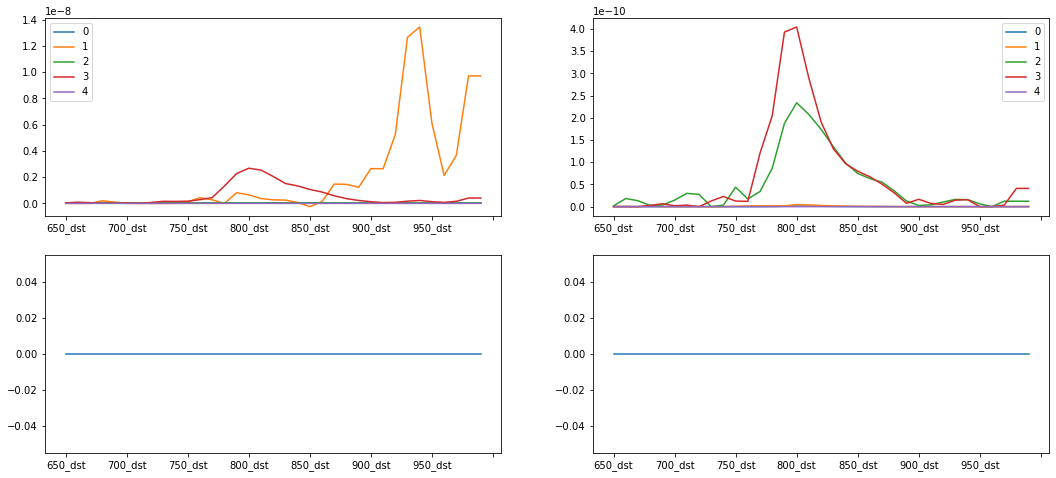

In [39]:
figure, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,8)
train_dst_i.head().T.plot(ax=ax1)
test_dst_i.head().T.plot(ax=ax2)
train_dst_i.isnull().sum().plot(ax=ax3)
test_dst_i.isnull().sum().plot(ax=ax4)